In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [59]:
from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary
import tensorflow as tf
import keras
from keras import layers, optimizers

# Data Processing

In [2]:
data = pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
data = data.loc[:,"statement":]
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [4]:
data = data.rename(columns = {"statement":"text", "status" : "label"})
data

,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [5]:
data['label'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [62]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming 'label' is the categorical column in your DataFrame
encode = OneHotEncoder(sparse=False)  # Use sparse=False to get a dense numpy array
one_hot = encode.fit_transform(data['label'].values.reshape(-1, 1))

# Create a DataFrame for the one-hot encoded labels
one_hot_df = pd.DataFrame(one_hot, columns=encode.get_feature_names_out(['label']))

# Drop the original 'label' column and concatenate the one-hot encoded DataFrame
data = pd.concat([data.drop('label', axis=1), one_hot_df], axis=1)

# Verify the result
print(data.head())


                                                text  label_0  label_1  \
0                                         oh my gosh      1.0      0.0   
1  trouble sleeping, confused mind, restless hear...      1.0      0.0   
2  All wrong, back off dear, forward doubt. Stay ...      1.0      0.0   
3  I've shifted my focus to something else but I'...      1.0      0.0   
4  I'm restless and restless, it's been a month n...      1.0      0.0   

   label_2  label_3  label_4  label_5  label_6  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0  


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [63]:
data.isnull().any()

text       True
label_0    True
label_1    True
label_2    True
label_3    True
label_4    True
label_5    True
label_6    True
dtype: bool

In [64]:
data = data.dropna(axis = 0)
data

,text,label_0,label_1,label_2,label_3,label_4,label_5,label_6
0,oh my gosh,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"trouble sleeping, confused mind, restless hear...",1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I've shifted my focus to something else but I'...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"I'm restless and restless, it's been a month n...",1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
52676,"MRI anxiety, what does Diazepam do to you? If ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0
52677,Long term Clonazapam?? \n\nLong term Klonopin?...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
52678,How to make friends? \nI have severe social an...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
52679,"Teeth Pain, Headaches, Hot Flushes I always fe...",1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
data.isnull().any()

text       False
label_0    False
label_1    False
label_2    False
label_3    False
label_4    False
label_5    False
label_6    False
dtype: bool

In [67]:
from sklearn.model_selection import train_test_split
labels = ['label_0','label_1','label_2','label_3','label_4','label_5','label_6']
train_df, other = train_test_split(
    data,
    test_size = 0.2,
    random_state = 9700,
    shuffle = True,
    stratify = data[labels],
)

In [68]:
val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9700,
    shuffle = True,
    stratify = other[labels],
)

In [69]:
len(train_df), len(val_df) ,len(test_df)

(41865, 5233, 5234)

In [71]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df[labels].values))
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df[labels].values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df[labels].values)
)

In [72]:
BATCH_SIZE = 64
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [73]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [74]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b'because of my hypersalivation i think that i have water in my lungs please help i had experienced hypersalivation for two years now (thats why i think that i have cancer) but i noticed that i have a hard time breathing and i can breathe on the fullest... also my belly (stomach i guess) became bigger on the upper part... i also feel like i have something on my stomach, its scarying me so much please help'
[1. 0. 0. 0. 0. 0. 0.]

b'sorry for the alt but people that still care about me use reddit and i cannot let them find out. my entire life sucks and i cannot take it anymore. whatever i do, i fuck everything up. everything i do goes wrong. if i breathe in, some bad thing happens in my environment. fuck that. my entire life is a failure and i cannot take it any longer. i do not care about anything anymore so i will just leave a note why my entire life sucks. doubt anyone will read anyway.i am ugly as fuck. i was born too early and i am extremely short. if i eat more than 1 meal a day i

In [75]:
reserved_tokens = ["[PAD]", "[UNK]"]

#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

120784


In [76]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1024).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [77]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [78]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [79]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'because of my hypersalivation i think that i have water in my lungs please help i had experienced hypersalivation for two years now (thats why i think that i have cancer) but i noticed that i have a hard time breathing and i can breathe on the fullest... also my belly (stomach i guess) became bigger on the upper part... i also feel like i have something on my stomach, its scarying me so much please help', shape=(), dtype=string)
Tokens:  tf.Tensor(
[  332   301   299  2965  8010 10177    48   360   306    48   305  1098
   308   299  3265   546   373    48   347  1027  2965  8010 10177   311
   534   384   348     9  2251   388    48   360   306    48   305   821
    10   309    48   987   306    48   305    40   462   346  1401   297
    48   330  1598   321   298  6849    15    15    15   420   299  4737
     9  1003    48   600    10   981  2009   321   298  2877   599    15
    15    15    48   420   320   316    48   305   396   321   299  1003
    13   390 

In [90]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [106]:
from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
def EmoAkinator():
    input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=False,
    )(input_ids)
    x = layers.LSTM(
            32, 
            activation = "tanh", 
            kernel_regularizer=regularizers.l2(0.001),
            use_cudnn=False)(x)
    outputs = Dense(7, activation="sigmoid")(x)
    # Compile the model
    model = Model(input_ids, outputs, name="BiEscalator")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=3e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [107]:
EmoAkinator2= EmoAkinator()
EmoAkinator2.summary()

Model: "BiEscalator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_8       │ (None, None, 128)           │      15,525,888 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,546,727 (59.31 MB)

 Trainable params: 15,546,727 (59.31 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
for inputs, targets in train_dataset.take(1):
    input_ids = inputs["input_ids"]
    break
embedding_layer = EmoAkinator1.layers[1]
mask = embedding_layer.compute_mask(input_ids)
print("Computed mask:", mask)

Computed mask: None


In [109]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.0973,
    patience = 3,
    verbose = 1,
    mode = "auto",
    min_delta = 1e-4,
    cooldown = 0,
    min_lr = 0,
)
earlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.001,
    patience = 10,
    verbose = 2,
    mode = "auto",
    restore_best_weights = True,
)
history = EmoAkinator2.fit(
    train_dataset,
    epochs=50, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR]
)

Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.3210 - loss: 1.7356 - val_accuracy: 0.3310 - val_loss: 1.6281 - learning_rate: 3.0000e-04
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.3245 - loss: 1.6182 - val_accuracy: 0.3327 - val_loss: 1.6071 - learning_rate: 3.0000e-04
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.3364 - loss: 1.5940 - val_accuracy: 0.3679 - val_loss: 1.5686 - learning_rate: 3.0000e-04
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.3385 - loss: 1.5911 - val_accuracy: 0.3323 - val_loss: 1.5940 - learning_rate: 3.0000e-04
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.3330 - loss: 1.5896 - val_accuracy: 0.3327 - val_loss: 1.5897 - learning_rate: 3.0000e-04
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3360 - loss: 1.5834
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9190001386450603e-05.
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - a

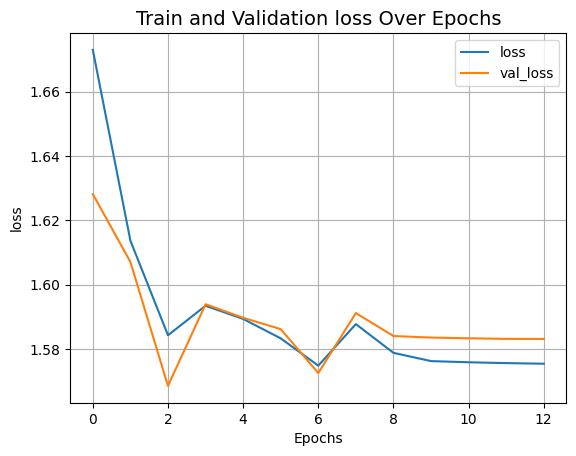

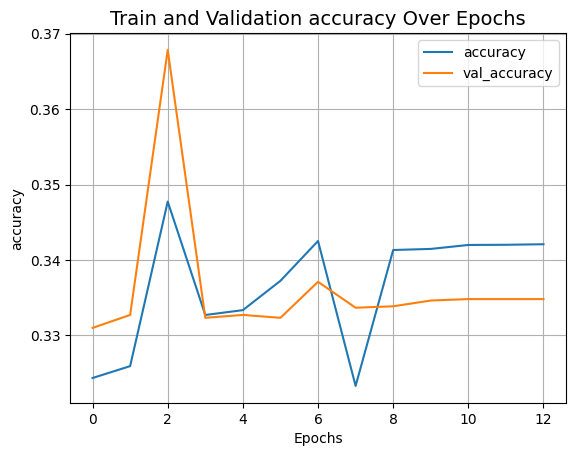

In [110]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [111]:
EmoAkinator2.evaluate(test_dataset)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3528 - loss: 1.5804


[1.570557713508606, 0.3639663755893707]